In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Capstone/transactions_dataset.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date_order     datetime64[ns]
 1   date_invoice   datetime64[ns]
 2   product_id     category      
 3   client_id      category      
 4   sales_net      float32       
 5   quantity       int32         
 6   order_channel  category      
 7   branch_id      category      
dtypes: category(4), datetime64[ns](2), float32(1), int32(1)
memory usage: 2.1 GB


In [ ]:
df = df.drop(columns='date_invoice')

In [ ]:
df.head()

,date_order,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2376333,188502,155.443207,3,online,2732
1,2017-09-25,2520527,835089,16.394400,3,at the store,10279
2,2017-09-25,2536756,1977896,365.766235,21,online,6184
3,2017-09-25,3028673,598816,8.598780,201,at the store,4200
4,2017-09-25,203377,2086861,1093.374023,3,by phone,7051


# Retention Curve

In [ ]:
retention_1 = df[df['sales_net']>0]

In [ ]:
retention_1.head()

,date_order,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2376333,188502,155.443207,3,online,2732
1,2017-09-25,2520527,835089,16.394400,3,at the store,10279
2,2017-09-25,2536756,1977896,365.766235,21,online,6184
3,2017-09-25,3028673,598816,8.598780,201,at the store,4200
4,2017-09-25,203377,2086861,1093.374023,3,by phone,7051


In [ ]:

import datetime as dt

# function to get month and month + date
def get_month(date):
      """
      enter the date data, return the data with date modified as first day of the month
      """
      return dt.datetime(date.year,date.month,1)

def get_date(df, column):
      """
      enter the dataframe and column, return the month and date in int. format
      """
      year = df[column].dt.year
      month = df[column].dt.month
      return year, month




In [ ]:
# First Billing Month
retention_1["BillMonth"] = retention_1["date_order"].apply(get_month)

<ipython-input-10-9b96d883cde0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_1["BillMonth"] = retention_1["date_order"].apply(get_month)


In [ ]:
# First Purchase Date
group = retention_1.groupby("client_id")["BillMonth"]
retention_1["CohortMonth"] = group.transform("min")
retention_1.head()

<ipython-input-11-88ef557f5718>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_1["CohortMonth"] = group.transform("min")


,date_order,product_id,client_id,sales_net,quantity,order_channel,branch_id,BillMonth,CohortMonth
0,2017-09-25,2376333,188502,155.443207,3,online,2732,2017-09-01,2017-09-01
1,2017-09-25,2520527,835089,16.394400,3,at the store,10279,2017-09-01,2017-09-01
2,2017-09-25,2536756,1977896,365.766235,21,online,6184,2017-09-01,2017-09-01
3,2017-09-25,3028673,598816,8.598780,201,at the store,4200,2017-09-01,2017-09-01
4,2017-09-25,203377,2086861,1093.374023,3,by phone,7051,2017-09-01,2017-09-01


In [ ]:
# Calculate the difference
BillYear, BillMonth = get_date(retention_1, "BillMonth")
CohortYear, CohortMonth = get_date(retention_1, "CohortMonth")

DiffYear = BillYear - CohortYear
DiffMonth = BillMonth - CohortMonth

retention_1["Month_Index"] = DiffYear * 12 + DiffMonth + 1



<ipython-input-12-c36396a247bd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_1["Month_Index"] = DiffYear * 12 + DiffMonth + 1


In [ ]:
# Long Term Loyal Customers. Filter the DataFrame to only include September and October cohorts with month indexes 23-25 and 22-24
mask = ((retention_1['CohortMonth'].dt.strftime('%Y-%m').str.startswith('2017-09') & retention_1['Month_Index'].between(23, 25))
        | (retention_1['CohortMonth'].dt.strftime('%Y-%m').str.startswith('2017-10') & retention_1['Month_Index'].between(22, 24)))
september_october_cohorts_df = retention_1[mask]

september_october_cohorts_df.head()

,date_order,product_id,client_id,sales_net,quantity,order_channel,branch_id,BillMonth,CohortMonth,Month_Index
30033804,2019-07-19,1062475,1172710,0.469200,3,by phone,9110,2019-07-01,2017-09-01,23
30083004,2019-07-19,259953,1172710,152.186401,3,by phone,9110,2019-07-01,2017-09-01,23
30153468,2019-07-19,714444,1172710,21.498236,35,by phone,9110,2019-07-01,2017-09-01,23
30159981,2019-07-19,2833938,1172710,35.430428,61,by phone,9110,2019-07-01,2017-09-01,23
30195488,2019-07-19,258965,1172710,33.644402,3,by phone,9110,2019-07-01,2017-09-01,23


In [ ]:
ltintercustomers_df = september_october_cohorts_df['client_id'].drop_duplicates()
ltintercustomers_df = ltintercustomers_df.reset_index(drop=True)
ltintercustomers_df.head()

ltintercustomers_df.to_csv('/content/drive/MyDrive/Capstone/Longterm_interacting_cust.csv')

In [ ]:
num_rows = len(ltintercustomers_df)
num_rows

59011

In [ ]:
group = retention_1.groupby(["CohortMonth", "Month_Index"])
cohort_data = group["client_id"].apply(pd.Series.nunique).reset_index() #count the unique customerID

cohort_data.head()

,CohortMonth,Month_Index,client_id
0,2017-09-01,1,39860
1,2017-09-01,2,35042
2,2017-09-01,3,33895
3,2017-09-01,4,32991
4,2017-09-01,5,32628


In [ ]:
# turn into pivot table
cohort_counts = cohort_data.pivot(index = "CohortMonth", columns = "Month_Index", values= "client_id")
cohort_counts

Month_Index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2017-09-01,39860.0,35042.0,33895.0,32991.0,32628.0,31881.0,32337.0,30253.0,29855.0,31527.0,...,29837.0,29082.0,28585.0,29226.0,28038.0,27381.0,28698.0,28977.0,29287.0,25658.0
2017-10-01,41439.0,25494.0,23583.0,23300.0,22374.0,23181.0,19666.0,19525.0,22378.0,22694.0,...,19638.0,18751.0,20009.0,18155.0,17229.0,19714.0,20377.0,21017.0,15169.0,NaN
2017-11-01,15198.0,6286.0,5860.0,5476.0,5826.0,4757.0,4633.0,5621.0,5622.0,5979.0,...,4472.0,4955.0,4386.0,4085.0,4804.0,5096.0,5373.0,3551.0,NaN,NaN
2017-12-01,9083.0,3357.0,2889.0,3047.0,2485.0,2336.0,2832.0,2854.0,3047.0,2335.0,...,2471.0,2225.0,2043.0,2437.0,2531.0,2679.0,1705.0,NaN,NaN,NaN
2018-01-01,7058.0,2332.0,2306.0,1783.0,1670.0,2059.0,2109.0,2195.0,1691.0,2030.0,...,1571.0,1547.0,1765.0,1908.0,1947.0,1269.0,NaN,NaN,NaN,NaN
2018-02-01,5243.0,1750.0,1313.0,1224.0,1468.0,1513.0,1576.0,1164.0,1457.0,1297.0,...,1031.0,1194.0,1312.0,1394.0,859.0,NaN,NaN,NaN,NaN,NaN
2018-03-01,5129.0,1445.0,1239.0,1392.0,1429.0,1527.0,1193.0,1363.0,1263.0,1197.0,...,1171.0,1231.0,1303.0,869.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,3312.0,976.0,957.0,943.0,967.0,730.0,863.0,804.0,751.0,722.0,...,757.0,779.0,549.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,2887.0,879.0,762.0,840.0,579.0,722.0,658.0,630.0,562.0,526.0,...,682.0,438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Set the first column as base = 100
cohort_sizes = cohort_counts.iloc[:, 0]

retention2 = cohort_counts.divide(cohort_sizes, axis = 0) * 100 #apply divide function to turn data into pct. (multiple base)
retention2.round(2)


Month_Index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2017-09-01,100.0,87.91,85.04,82.77,81.86,79.98,81.13,75.90,74.90,79.09,...,74.85,72.96,71.71,73.32,70.34,68.69,72.00,72.70,73.47,64.37
2017-10-01,100.0,61.52,56.91,56.23,53.99,55.94,47.46,47.12,54.00,54.76,...,47.39,45.25,48.29,43.81,41.58,47.57,49.17,50.72,36.61,NaN
2017-11-01,100.0,41.36,38.56,36.03,38.33,31.30,30.48,36.99,36.99,39.34,...,29.42,32.60,28.86,26.88,31.61,33.53,35.35,23.36,NaN,NaN
2017-12-01,100.0,36.96,31.81,33.55,27.36,25.72,31.18,31.42,33.55,25.71,...,27.20,24.50,22.49,26.83,27.87,29.49,18.77,NaN,NaN,NaN
2018-01-01,100.0,33.04,32.67,25.26,23.66,29.17,29.88,31.10,23.96,28.76,...,22.26,21.92,25.01,27.03,27.59,17.98,NaN,NaN,NaN,NaN
2018-02-01,100.0,33.38,25.04,23.35,28.00,28.86,30.06,22.20,27.79,24.74,...,19.66,22.77,25.02,26.59,16.38,NaN,NaN,NaN,NaN,NaN
2018-03-01,100.0,28.17,24.16,27.14,27.86,29.77,23.26,26.57,24.62,23.34,...,22.83,24.00,25.40,16.94,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,100.0,29.47,28.89,28.47,29.20,22.04,26.06,24.28,22.68,21.80,...,22.86,23.52,16.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,100.0,30.45,26.39,29.10,20.06,25.01,22.79,21.82,19.47,18.22,...,23.62,15.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
month_list = ["Sep 2017", 
            "Oct 2017", "Nov 2017", "Dec 2017", "Jan 2018", "Feb 2018", "Mar 2018", "Apr 2018", "May 2018", "Jun 2018", "Jul 2018", "Aug 2018", "Sep 2018", 
            "Oct 2018", "Nov 2018", "Dec 2018", "Jan 2019", "Feb 2019", "Mar 2019", "Apr 2019", "May 2019", "Jun 2019", "Jul 2019", "Aug 2019", "Sep 2019"]

Text(0.5, 1.0, 'Monthly Cohort Retention Sep 2017 to Sep 2019')

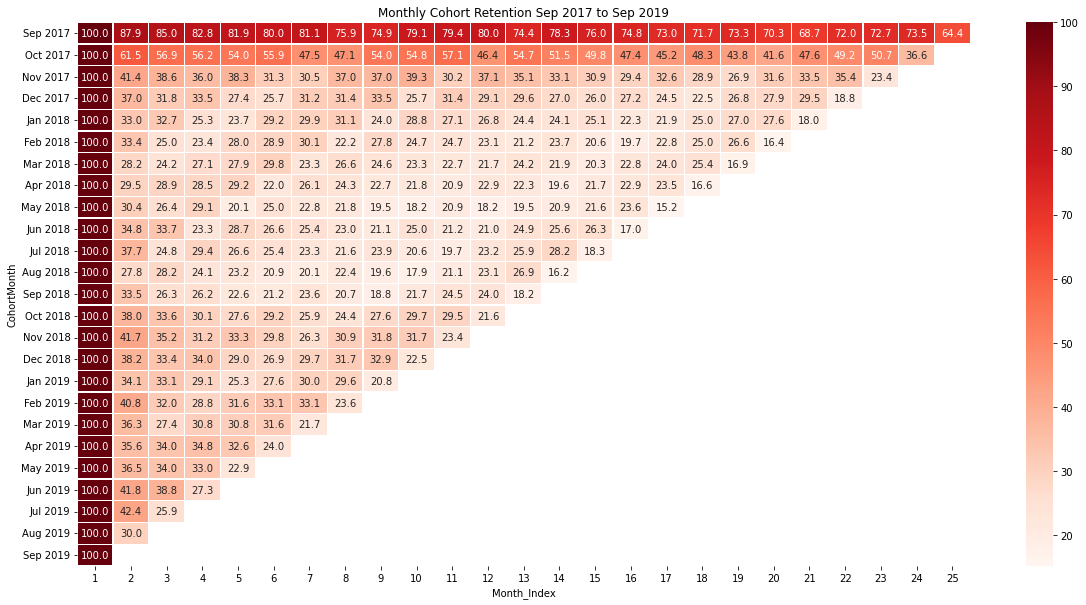

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(data = retention2.round(2), annot = True, cmap = "Reds", fmt = ".1f", linewidths = 0.2, yticklabels = month_list)
plt.title("Monthly Client  Sep 2017 to Sep 2019")

# plt.savefig('Retention_Cohorts.jpeg',
#             bbox_inches='tight',
#             pad_inches=0.1,
#             format='jpeg',
#             dpi=300)